###Implementación de CNN para predicción de trayectoria de peatones

In [ ]:
#!unzip '/content/drive/MyDrive/ProyectoSL2/data/stanford-dataset-meters.zip' -d '/content/drive/MyDrive/ProyectoSL2/data/standford-dataset-meters'


Instalación de wandb para observar el comportamiento de los parametros del modelo

In [ ]:
!pip install wandb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import wandb
from wandb.keras import WandbCallback

wandb.init(project="ProyectoSL2")

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: silvya. Use `wandb login --relogin` to force relogin


####Preparación de Datos a utilizar

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf

In [ ]:
#Funcion para dividir una sequencia multivariable en muestras
def split_sequences(sequences, n_steps_in, n_steps_out):
	X, y = list(), list()
	for i in range(len(sequences)):
		# Encontrar el final del patron
		end_ix = i + n_steps_in
		out_end_ix = end_ix + n_steps_out
		
		if out_end_ix > len(sequences):# verificar que si se llego al final del dataset
			break
		# unir entradas y salidas del patron
		seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix:out_end_ix, :]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)

In [ ]:
from random import Random	

#funcion para preparar la estructura de los datos para poder utilizarlo con estructura de aprendizaje supervisado
def sequences_to_supervised(dataframe, n_steps_in, n_steps_out, n_features):
  X_all = np.empty([0,n_steps_in,n_features]) # n_features = number of features: x, y
  y_all = np.empty([0,n_steps_out,n_features]) # n_features = number of features: x,y
       
  dataframe_groups = dataframe.groupby(['id']) #se agrupan las secuencias de cada peaton
  
  groups = list(dataframe.groupby(['id'])) 
  Random(1).shuffle(groups)  #secuencias aleatorias agrupadas por el id del peaton
 

  for group in groups:
    X, y = split_sequences(group[1].drop(columns=["id"]).values, n_steps_in,n_steps_out) # 2 features, x, y
         
    X_all = np.concatenate((X_all,X))
    y_all = np.concatenate((y_all,y))
                   
  return X_all, y_all   

In [ ]:
n_features = 2   # features x, y (posicion del peaton en un tiempo t)
n_steps_in = 8   # 8 pasos de entrada (secuencia de trayectoria inicial)
n_steps_out = 12 # 12 pasos de salida (secuencia de trayectoria a predecir)

Extracción y carga de datos a utilizar para el entrenamiento del modelo

In [ ]:
#los datos se encuentran en archivos por separado, se unen archivos para el training data
train_files = ['/content/drive/MyDrive/ProyectoSL2/data/standford-dataset-meters/train/bookstore_0.txt',
               '/content/drive/MyDrive/ProyectoSL2/data/standford-dataset-meters/train/bookstore_1.txt',
               '/content/drive/MyDrive/ProyectoSL2/data/standford-dataset-meters/train/bookstore_2.txt']

df =pd.DataFrame()

for i in range(len(train_files)):
  data = pd.read_csv(train_files[i],sep=' ', header=None, names=['time','id','x','y'])
  data['id'] = data['id'].apply(lambda x: str(i)+str(x))

  df = pd.concat([df,data],ignore_index=True)

El dataset contiene cuatro columnas 

**id:** el id del peaton

**time:** contiene el tiempo de la secuencia de trayectoria de un peaton, son 20 timestep por cada peaton.

**x:** coordenada x en metros de la posición en un punto de la secuencia de trayectoria 

**y:** coordenada y en metros de la posicion en un punto de la secuencia de trayectoria 

In [ ]:
df.head(40)

,time,id,x,y
0,0,0100,1.728,14.378
1,12,0100,2.035,14.378
2,24,0100,2.342,14.378
3,36,0100,2.630,14.378
4,48,0100,2.937,14.416
5,60,0100,3.244,14.416
6,72,0100,3.551,14.416
7,84,0100,3.782,14.416
8,96,0100,4.089,14.416
9,108,0100,4.242,14.512


El dataset contiene en total 1772 trayectorias

Las posiciones son de una imagen en un plano con coordenadas (x,y), con el origen en medio de la imagen, por esto se tienen coordenas positivas y negativas. 

Coordenadas  -28.579 < x < 28.518, -21.754 < y < 21.714

Con lo que se obtiene un área de estudio de 2481.89 metros cuadrados

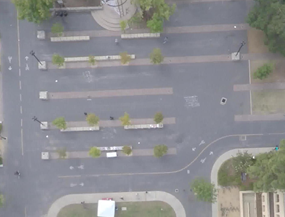

In [ ]:
df.describe(include='all')

,time,id,x,y
count,35440.000000,35440,35440.000000,35440.000000
unique,NaN,1772,NaN,NaN
top,NaN,0100,NaN,NaN
freq,NaN,20,NaN,NaN
mean,7143.284424,NaN,-1.710165,2.422755
std,4040.345357,NaN,14.818010,12.437575
min,0.000000,NaN,-28.579000,-21.754000
25%,3552.000000,NaN,-14.005250,-9.175000
50%,7332.000000,NaN,-3.321000,2.380000
75%,10536.000000,NaN,9.291000,15.683000


Normalización de los datos de entrenamiento:

In [ ]:
from sklearn.preprocessing import MinMaxScaler

id_column = df.id
df.drop(columns=['time','id'], axis=1, inplace=True) #se quita la feature time del dataset

#Normalizando datos de posición
scaler = MinMaxScaler()
df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns) #se normalizan unicamente las feature x,y

df['id'] = id_column

import pickle as pkl
with open('/content/drive/MyDrive/ProyectoSL2/data/models/CNN/scaler.pkl', 'wb') as outfile: #se guarda el scaler para poder desnormalizar despues los datos
  pkl.dump(scaler, outfile)

Training data normalizados:

In [ ]:
df.head(5)

,x,y,id
0,0.530798,0.831232,0100
1,0.536175,0.831232,0100
2,0.541552,0.831232,0100
3,0.546596,0.831232,0100
4,0.551973,0.832106,0100


In [ ]:
#división de features x, y para utilizarlos en el modelo de entrada multiple
X,y = sequences_to_supervised(df,n_steps_in,n_steps_out, n_features)


In [ ]:
print(X.shape) #1772 muestras, de 8 pasos de entrada, con 2 caracteristicas (posicion coordenadas x,y)
print(y.shape) #1772 muestras, de 12 pasos de salida, con 2 caracteristicas (posicion coordenadas x,y)

(1772, 8, 2)
(1772, 12, 2)


In [ ]:
print("X:",X.shape[0],"muestras, de",X.shape[1],"pasos de entrada, con",X.shape[2],"caracteristicas que corresponden a las coordenadas de la posición")
print("y:",y.shape[0],"muestras, de",y.shape[1],"pasos de salida, con",y.shape[2],"caracteristicas que corresponden a las coordenadas de la posición")

X: 1772 muestras, de 8 pasos de entrada, con 2 caracteristicas que corresponden a las coordenadas de la posición
y: 1772 muestras, de 12 pasos de salida, con 2 caracteristicas que corresponden a las coordenadas de la posición


Redimension de la salida:

In [ ]:
y= y.reshape((y.shape[0],(12*2))) #flatten output 24

####Creación modelo CNN

#####Creación de la estructura:

In [ ]:
n_timesteps = 8
n_features = 2
n_outputs =12

model = tf.keras.Sequential()

model.add(tf.keras.layers.Conv1D(filters=128, kernel_size=2, activation='relu', input_shape=(n_timesteps,n_features))) #Capa de 1D
model.add(tf.keras.layers.MaxPooling1D(pool_size=2))

model.add(tf.keras.layers.Flatten())

model.add(tf.keras.layers.Dense(100, activation='relu'))
model.add(tf.keras.layers.Dense(12*2, activation='linear'))

model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, epsilon=1e-08, decay=0.0), loss='mse')


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 7, 128)            640       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 3, 128)           0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 384)               0         
                                                                 
 dense (Dense)               (None, 100)               38500     
                                                                 
 dense_1 (Dense)             (None, 24)                2424      
                                                                 
Total params: 41,564
Trainable params: 41,564
Non-trainable params: 0
____________________________________________________

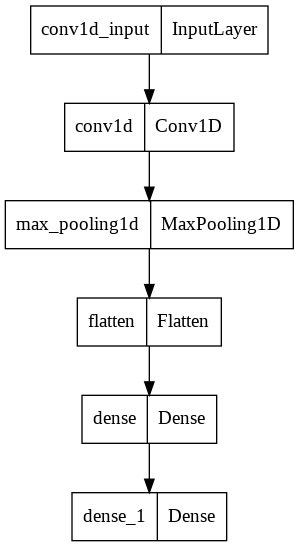

In [ ]:
tf.keras.utils.plot_model(model)

In [ ]:
#callback para monitorear el costo
wandb_callback = WandbCallback(monitor='val_loss', mode='min', log_gradients=False)

wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


#####Entrenamiento del modelo:

In [ ]:
model.fit(X,y, epochs=400, validation_split=0.2, callbacks=[wandb_callback], batch_size=32)

Instructions for updating:
Use `tf.compat.v1.graph_util.tensor_shape_from_node_def_name`


Epoch 1/400
33/45 [=====================>........] - ETA: 0s - loss: 0.1219

wandb: Adding directory to artifact (/content/wandb/run-20220919_125736-211s322i/files/model-best)... Done. 0.1s


45/45 [==============================] - 2s 31ms/step - loss: 0.0955 - val_loss: 0.0109
Epoch 2/400
34/45 [=====================>........] - ETA: 0s - loss: 0.0069

wandb: Adding directory to artifact (/content/wandb/run-20220919_125736-211s322i/files/model-best)... Done. 0.1s


45/45 [==============================] - 1s 25ms/step - loss: 0.0062 - val_loss: 0.0033
Epoch 3/400
40/45 [=========================>....] - ETA: 0s - loss: 0.0035

wandb: Adding directory to artifact (/content/wandb/run-20220919_125736-211s322i/files/model-best)... Done. 0.1s


45/45 [==============================] - 1s 23ms/step - loss: 0.0034 - val_loss: 0.0031
Epoch 4/400
41/45 [==========================>...] - ETA: 0s - loss: 0.0033

wandb: Adding directory to artifact (/content/wandb/run-20220919_125736-211s322i/files/model-best)... Done. 0.1s


45/45 [==============================] - 1s 24ms/step - loss: 0.0033 - val_loss: 0.0030
Epoch 5/400
45/45 [==============================] - 0s 4ms/step - loss: 0.0031 - val_loss: 0.0031
Epoch 6/400
40/45 [=========================>....] - ETA: 0s - loss: 0.0030

wandb: Adding directory to artifact (/content/wandb/run-20220919_125736-211s322i/files/model-best)... Done. 0.1s


45/45 [==============================] - 1s 30ms/step - loss: 0.0031 - val_loss: 0.0030
Epoch 7/400
33/45 [=====================>........] - ETA: 0s - loss: 0.0029

wandb: Adding directory to artifact (/content/wandb/run-20220919_125736-211s322i/files/model-best)... Done. 0.1s


45/45 [==============================] - 1s 25ms/step - loss: 0.0030 - val_loss: 0.0028
Epoch 8/400
42/45 [===========================>..] - ETA: 0s - loss: 0.0029

wandb: Adding directory to artifact (/content/wandb/run-20220919_125736-211s322i/files/model-best)... Done. 0.1s


45/45 [==============================] - 1s 25ms/step - loss: 0.0029 - val_loss: 0.0028
Epoch 9/400
41/45 [==========================>...] - ETA: 0s - loss: 0.0030

wandb: Adding directory to artifact (/content/wandb/run-20220919_125736-211s322i/files/model-best)... Done. 0.1s


45/45 [==============================] - 2s 35ms/step - loss: 0.0030 - val_loss: 0.0026
Epoch 10/400
45/45 [==============================] - 0s 3ms/step - loss: 0.0028 - val_loss: 0.0026
Epoch 11/400
45/45 [==============================] - 0s 4ms/step - loss: 0.0029 - val_loss: 0.0026
Epoch 12/400
44/45 [============================>.] - ETA: 0s - loss: 0.0027

wandb: Adding directory to artifact (/content/wandb/run-20220919_125736-211s322i/files/model-best)... Done. 0.1s


45/45 [==============================] - 1s 25ms/step - loss: 0.0027 - val_loss: 0.0026
Epoch 13/400
45/45 [==============================] - 0s 4ms/step - loss: 0.0026 - val_loss: 0.0027
Epoch 14/400
39/45 [=========================>....] - ETA: 0s - loss: 0.0027

wandb: Adding directory to artifact (/content/wandb/run-20220919_125736-211s322i/files/model-best)... Done. 0.1s


45/45 [==============================] - 1s 24ms/step - loss: 0.0027 - val_loss: 0.0023
Epoch 15/400
45/45 [==============================] - 0s 4ms/step - loss: 0.0025 - val_loss: 0.0026
Epoch 16/400
40/45 [=========================>....] - ETA: 0s - loss: 0.0024

wandb: Adding directory to artifact (/content/wandb/run-20220919_125736-211s322i/files/model-best)... Done. 0.1s


45/45 [==============================] - 1s 24ms/step - loss: 0.0024 - val_loss: 0.0022
Epoch 17/400
42/45 [===========================>..] - ETA: 0s - loss: 0.0023

wandb: Adding directory to artifact (/content/wandb/run-20220919_125736-211s322i/files/model-best)... Done. 0.1s


45/45 [==============================] - 1s 24ms/step - loss: 0.0023 - val_loss: 0.0020
Epoch 18/400
42/45 [===========================>..] - ETA: 0s - loss: 0.0021

wandb: Adding directory to artifact (/content/wandb/run-20220919_125736-211s322i/files/model-best)... Done. 0.1s


45/45 [==============================] - 1s 31ms/step - loss: 0.0021 - val_loss: 0.0018
Epoch 19/400
45/45 [==============================] - 0s 4ms/step - loss: 0.0021 - val_loss: 0.0020
Epoch 20/400
42/45 [===========================>..] - ETA: 0s - loss: 0.0019

wandb: Adding directory to artifact (/content/wandb/run-20220919_125736-211s322i/files/model-best)... Done. 0.1s


45/45 [==============================] - 1s 24ms/step - loss: 0.0019 - val_loss: 0.0016
Epoch 21/400
45/45 [==============================] - 0s 4ms/step - loss: 0.0018 - val_loss: 0.0017
Epoch 22/400
33/45 [=====================>........] - ETA: 0s - loss: 0.0016

wandb: Adding directory to artifact (/content/wandb/run-20220919_125736-211s322i/files/model-best)... Done. 0.1s


45/45 [==============================] - 1s 26ms/step - loss: 0.0016 - val_loss: 0.0014
Epoch 23/400
40/45 [=========================>....] - ETA: 0s - loss: 0.0016

wandb: Adding directory to artifact (/content/wandb/run-20220919_125736-211s322i/files/model-best)... Done. 0.1s


45/45 [==============================] - 1s 25ms/step - loss: 0.0015 - val_loss: 0.0013
Epoch 24/400
39/45 [=========================>....] - ETA: 0s - loss: 0.0015

wandb: Adding directory to artifact (/content/wandb/run-20220919_125736-211s322i/files/model-best)... Done. 0.1s


45/45 [==============================] - 1s 24ms/step - loss: 0.0014 - val_loss: 0.0012
Epoch 25/400
40/45 [=========================>....] - ETA: 0s - loss: 0.0014

wandb: Adding directory to artifact (/content/wandb/run-20220919_125736-211s322i/files/model-best)... Done. 0.1s


45/45 [==============================] - 1s 25ms/step - loss: 0.0014 - val_loss: 0.0011
Epoch 26/400
37/45 [=======================>......] - ETA: 0s - loss: 0.0013

wandb: Adding directory to artifact (/content/wandb/run-20220919_125736-211s322i/files/model-best)... Done. 0.1s


45/45 [==============================] - 1s 25ms/step - loss: 0.0013 - val_loss: 0.0010
Epoch 27/400
39/45 [=========================>....] - ETA: 0s - loss: 0.0011

wandb: Adding directory to artifact (/content/wandb/run-20220919_125736-211s322i/files/model-best)... Done. 0.1s


45/45 [==============================] - 1s 24ms/step - loss: 0.0012 - val_loss: 9.1253e-04
Epoch 28/400
45/45 [==============================] - 0s 4ms/step - loss: 0.0011 - val_loss: 0.0010
Epoch 29/400
37/45 [=======================>......] - ETA: 0s - loss: 0.0011

wandb: Adding directory to artifact (/content/wandb/run-20220919_125736-211s322i/files/model-best)... Done. 0.1s


45/45 [==============================] - 1s 24ms/step - loss: 0.0011 - val_loss: 8.5728e-04
Epoch 30/400
45/45 [==============================] - 0s 5ms/step - loss: 0.0011 - val_loss: 8.6660e-04
Epoch 31/400
45/45 [==============================] - 0s 4ms/step - loss: 9.8708e-04 - val_loss: 0.0010
Epoch 32/400
45/45 [==============================] - 0s 4ms/step - loss: 0.0010 - val_loss: 0.0017
Epoch 33/400
40/45 [=========================>....] - ETA: 0s - loss: 9.4773e-04

wandb: Adding directory to artifact (/content/wandb/run-20220919_125736-211s322i/files/model-best)... Done. 0.1s


45/45 [==============================] - 1s 32ms/step - loss: 9.4763e-04 - val_loss: 7.3833e-04
Epoch 34/400
34/45 [=====================>........] - ETA: 0s - loss: 9.0601e-04

wandb: Adding directory to artifact (/content/wandb/run-20220919_125736-211s322i/files/model-best)... Done. 0.1s


45/45 [==============================] - 1s 29ms/step - loss: 9.2082e-04 - val_loss: 6.7999e-04
Epoch 35/400
45/45 [==============================] - 0s 4ms/step - loss: 8.4761e-04 - val_loss: 0.0011
Epoch 36/400
37/45 [=======================>......] - ETA: 0s - loss: 8.7743e-04

wandb: Adding directory to artifact (/content/wandb/run-20220919_125736-211s322i/files/model-best)... Done. 0.1s


45/45 [==============================] - 1s 27ms/step - loss: 8.3815e-04 - val_loss: 6.1057e-04
Epoch 37/400
45/45 [==============================] - 0s 4ms/step - loss: 7.8834e-04 - val_loss: 8.1940e-04
Epoch 38/400
45/45 [==============================] - 0s 4ms/step - loss: 8.8930e-04 - val_loss: 7.0207e-04
Epoch 39/400
45/45 [==============================] - 0s 4ms/step - loss: 7.8377e-04 - val_loss: 6.9003e-04
Epoch 40/400
45/45 [==============================] - 0s 5ms/step - loss: 8.3092e-04 - val_loss: 6.5778e-04
Epoch 41/400
45/45 [==============================] - 0s 5ms/step - loss: 7.0281e-04 - val_loss: 6.7397e-04
Epoch 42/400
32/45 [====================>.........] - ETA: 0s - loss: 6.2963e-04

wandb: Adding directory to artifact (/content/wandb/run-20220919_125736-211s322i/files/model-best)... Done. 0.1s


45/45 [==============================] - 1s 26ms/step - loss: 6.5708e-04 - val_loss: 5.6617e-04
Epoch 43/400
45/45 [==============================] - 0s 5ms/step - loss: 6.6902e-04 - val_loss: 7.8413e-04
Epoch 44/400
45/45 [==============================] - 0s 4ms/step - loss: 8.4108e-04 - val_loss: 7.3413e-04
Epoch 45/400
38/45 [========================>.....] - ETA: 0s - loss: 6.3101e-04

wandb: Adding directory to artifact (/content/wandb/run-20220919_125736-211s322i/files/model-best)... Done. 0.1s


45/45 [==============================] - 1s 26ms/step - loss: 6.2469e-04 - val_loss: 5.1324e-04
Epoch 46/400
38/45 [========================>.....] - ETA: 0s - loss: 6.5597e-04

wandb: Adding directory to artifact (/content/wandb/run-20220919_125736-211s322i/files/model-best)... Done. 0.1s


45/45 [==============================] - 1s 27ms/step - loss: 6.4531e-04 - val_loss: 4.8692e-04
Epoch 47/400
34/45 [=====================>........] - ETA: 0s - loss: 5.0870e-04

wandb: Adding directory to artifact (/content/wandb/run-20220919_125736-211s322i/files/model-best)... Done. 0.1s


45/45 [==============================] - 1s 27ms/step - loss: 5.7853e-04 - val_loss: 4.6874e-04
Epoch 48/400
45/45 [==============================] - 0s 5ms/step - loss: 8.6034e-04 - val_loss: 0.0011
Epoch 49/400
45/45 [==============================] - 0s 5ms/step - loss: 6.0150e-04 - val_loss: 5.6802e-04
Epoch 50/400
35/45 [======================>.......] - ETA: 0s - loss: 5.4148e-04

wandb: Adding directory to artifact (/content/wandb/run-20220919_125736-211s322i/files/model-best)... Done. 0.1s


45/45 [==============================] - 1s 26ms/step - loss: 5.4525e-04 - val_loss: 4.3145e-04
Epoch 51/400
35/45 [======================>.......] - ETA: 0s - loss: 4.6714e-04

wandb: Adding directory to artifact (/content/wandb/run-20220919_125736-211s322i/files/model-best)... Done. 0.1s


45/45 [==============================] - 1s 26ms/step - loss: 4.7474e-04 - val_loss: 3.9776e-04
Epoch 52/400
36/45 [=======================>......] - ETA: 0s - loss: 5.3234e-04

wandb: Adding directory to artifact (/content/wandb/run-20220919_125736-211s322i/files/model-best)... Done. 0.1s


45/45 [==============================] - 1s 33ms/step - loss: 5.1687e-04 - val_loss: 3.9008e-04
Epoch 53/400
45/45 [==============================] - 0s 5ms/step - loss: 4.7763e-04 - val_loss: 4.6657e-04
Epoch 54/400
45/45 [==============================] - 0s 4ms/step - loss: 4.9593e-04 - val_loss: 4.0072e-04
Epoch 55/400
45/45 [==============================] - 0s 5ms/step - loss: 4.6920e-04 - val_loss: 4.5249e-04
Epoch 56/400
39/45 [=========================>....] - ETA: 0s - loss: 4.2852e-04

wandb: Adding directory to artifact (/content/wandb/run-20220919_125736-211s322i/files/model-best)... Done. 0.1s


45/45 [==============================] - 1s 25ms/step - loss: 4.3490e-04 - val_loss: 3.4757e-04
Epoch 57/400
45/45 [==============================] - 0s 4ms/step - loss: 4.6097e-04 - val_loss: 5.2529e-04
Epoch 58/400
45/45 [==============================] - 0s 4ms/step - loss: 5.3418e-04 - val_loss: 5.7784e-04
Epoch 59/400
45/45 [==============================] - 0s 5ms/step - loss: 4.0382e-04 - val_loss: 3.7784e-04
Epoch 60/400
41/45 [==========================>...] - ETA: 0s - loss: 4.0697e-04

wandb: Adding directory to artifact (/content/wandb/run-20220919_125736-211s322i/files/model-best)... Done. 0.1s


45/45 [==============================] - 1s 24ms/step - loss: 3.9980e-04 - val_loss: 3.0584e-04
Epoch 61/400
45/45 [==============================] - 0s 4ms/step - loss: 3.8367e-04 - val_loss: 3.4362e-04
Epoch 62/400
45/45 [==============================] - 0s 4ms/step - loss: 3.7975e-04 - val_loss: 3.3489e-04
Epoch 63/400
45/45 [==============================] - 0s 4ms/step - loss: 4.6743e-04 - val_loss: 3.1369e-04
Epoch 64/400
45/45 [==============================] - 0s 5ms/step - loss: 4.2272e-04 - val_loss: 4.6380e-04
Epoch 65/400
45/45 [==============================] - 0s 3ms/step - loss: 3.6825e-04 - val_loss: 3.1537e-04
Epoch 66/400
33/45 [=====================>........] - ETA: 0s - loss: 4.6714e-04

wandb: Adding directory to artifact (/content/wandb/run-20220919_125736-211s322i/files/model-best)... Done. 0.1s


45/45 [==============================] - 1s 25ms/step - loss: 4.4039e-04 - val_loss: 3.0473e-04
Epoch 67/400
45/45 [==============================] - 0s 4ms/step - loss: 3.6694e-04 - val_loss: 5.2893e-04
Epoch 68/400
45/45 [==============================] - 0s 4ms/step - loss: 3.8812e-04 - val_loss: 4.1743e-04
Epoch 69/400
35/45 [======================>.......] - ETA: 0s - loss: 4.3170e-04

wandb: Adding directory to artifact (/content/wandb/run-20220919_125736-211s322i/files/model-best)... Done. 0.1s


45/45 [==============================] - 1s 25ms/step - loss: 4.0485e-04 - val_loss: 2.7554e-04
Epoch 70/400
45/45 [==============================] - 0s 4ms/step - loss: 3.6359e-04 - val_loss: 3.6965e-04
Epoch 71/400
45/45 [==============================] - 0s 5ms/step - loss: 4.6185e-04 - val_loss: 3.8186e-04
Epoch 72/400
45/45 [==============================] - 0s 4ms/step - loss: 4.1929e-04 - val_loss: 3.5479e-04
Epoch 73/400
45/45 [==============================] - 0s 4ms/step - loss: 3.7397e-04 - val_loss: 6.5582e-04
Epoch 74/400
45/45 [==============================] - 0s 4ms/step - loss: 4.0960e-04 - val_loss: 2.7947e-04
Epoch 75/400
45/45 [==============================] - 0s 4ms/step - loss: 3.5406e-04 - val_loss: 5.0589e-04
Epoch 76/400
45/45 [==============================] - 0s 4ms/step - loss: 4.0543e-04 - val_loss: 4.2101e-04
Epoch 77/400
45/45 [==============================] - 0s 4ms/step - loss: 4.0374e-04 - val_loss: 4.8455e-04
Epoch 78/400
45/45 [====================

wandb: Adding directory to artifact (/content/wandb/run-20220919_125736-211s322i/files/model-best)... Done. 0.1s


45/45 [==============================] - 1s 24ms/step - loss: 4.4862e-04 - val_loss: 2.6819e-04
Epoch 88/400
45/45 [==============================] - 0s 4ms/step - loss: 3.5904e-04 - val_loss: 5.6428e-04
Epoch 89/400
45/45 [==============================] - 0s 4ms/step - loss: 4.0056e-04 - val_loss: 4.5476e-04
Epoch 90/400
45/45 [==============================] - 0s 4ms/step - loss: 4.6066e-04 - val_loss: 2.8613e-04
Epoch 91/400
45/45 [==============================] - 0s 5ms/step - loss: 3.6959e-04 - val_loss: 3.2283e-04
Epoch 92/400
45/45 [==============================] - 0s 4ms/step - loss: 3.4343e-04 - val_loss: 4.6867e-04
Epoch 93/400
45/45 [==============================] - 0s 4ms/step - loss: 3.8355e-04 - val_loss: 3.7752e-04
Epoch 94/400
45/45 [==============================] - 0s 4ms/step - loss: 3.5117e-04 - val_loss: 2.9765e-04
Epoch 95/400
45/45 [==============================] - 0s 4ms/step - loss: 3.7215e-04 - val_loss: 3.9253e-04
Epoch 96/400
45/45 [====================

wandb: Adding directory to artifact (/content/wandb/run-20220919_125736-211s322i/files/model-best)... Done. 0.1s


45/45 [==============================] - 1s 23ms/step - loss: 3.8150e-04 - val_loss: 2.6743e-04
Epoch 152/400
45/45 [==============================] - 0s 4ms/step - loss: 3.8298e-04 - val_loss: 2.9014e-04
Epoch 153/400
45/45 [==============================] - 0s 3ms/step - loss: 3.2534e-04 - val_loss: 3.5826e-04
Epoch 154/400
45/45 [==============================] - 0s 3ms/step - loss: 3.5050e-04 - val_loss: 2.9503e-04
Epoch 155/400
45/45 [==============================] - 0s 4ms/step - loss: 3.4013e-04 - val_loss: 2.8244e-04
Epoch 156/400
45/45 [==============================] - 0s 4ms/step - loss: 3.7332e-04 - val_loss: 4.6348e-04
Epoch 157/400
45/45 [==============================] - 0s 4ms/step - loss: 3.8984e-04 - val_loss: 4.8297e-04
Epoch 158/400
45/45 [==============================] - 0s 4ms/step - loss: 4.5705e-04 - val_loss: 4.1574e-04
Epoch 159/400
45/45 [==============================] - 0s 4ms/step - loss: 3.2934e-04 - val_loss: 3.8131e-04
Epoch 160/400
45/45 [===========

wandb: Adding directory to artifact (/content/wandb/run-20220919_125736-211s322i/files/model-best)... Done. 0.1s


45/45 [==============================] - 3s 69ms/step - loss: 3.2868e-04 - val_loss: 2.6517e-04
Epoch 173/400
45/45 [==============================] - 0s 4ms/step - loss: 3.0164e-04 - val_loss: 3.1645e-04
Epoch 174/400
45/45 [==============================] - 0s 5ms/step - loss: 3.5866e-04 - val_loss: 3.9614e-04
Epoch 175/400
45/45 [==============================] - 0s 3ms/step - loss: 3.2518e-04 - val_loss: 3.0118e-04
Epoch 176/400
45/45 [==============================] - 0s 4ms/step - loss: 3.4116e-04 - val_loss: 3.1990e-04
Epoch 177/400
45/45 [==============================] - 0s 4ms/step - loss: 3.7378e-04 - val_loss: 4.1368e-04
Epoch 178/400
45/45 [==============================] - 0s 3ms/step - loss: 3.4583e-04 - val_loss: 2.8751e-04
Epoch 179/400
45/45 [==============================] - 0s 4ms/step - loss: 3.6854e-04 - val_loss: 4.0356e-04
Epoch 180/400
45/45 [==============================] - 0s 3ms/step - loss: 3.5014e-04 - val_loss: 3.1390e-04
Epoch 181/400
45/45 [===========

wandb: Adding directory to artifact (/content/wandb/run-20220919_125736-211s322i/files/model-best)... Done. 0.1s


45/45 [==============================] - 1s 30ms/step - loss: 2.9180e-04 - val_loss: 2.6461e-04
Epoch 358/400
45/45 [==============================] - 0s 4ms/step - loss: 3.5948e-04 - val_loss: 3.4378e-04
Epoch 359/400
45/45 [==============================] - 0s 4ms/step - loss: 3.4189e-04 - val_loss: 2.9745e-04
Epoch 360/400
45/45 [==============================] - 0s 4ms/step - loss: 3.1532e-04 - val_loss: 3.4111e-04
Epoch 361/400
45/45 [==============================] - 0s 4ms/step - loss: 2.9867e-04 - val_loss: 2.6783e-04
Epoch 362/400
45/45 [==============================] - 0s 4ms/step - loss: 3.1600e-04 - val_loss: 2.7932e-04
Epoch 363/400
45/45 [==============================] - 0s 4ms/step - loss: 2.9048e-04 - val_loss: 3.0760e-04
Epoch 364/400
45/45 [==============================] - 0s 4ms/step - loss: 3.4664e-04 - val_loss: 3.3689e-04
Epoch 365/400
45/45 [==============================] - 0s 4ms/step - loss: 3.0781e-04 - val_loss: 2.7848e-04
Epoch 366/400
45/45 [===========

wandb: Adding directory to artifact (/content/wandb/run-20220919_125736-211s322i/files/model-best)... Done. 0.1s


45/45 [==============================] - 1s 23ms/step - loss: 2.8176e-04 - val_loss: 2.6254e-04
Epoch 373/400
45/45 [==============================] - 0s 4ms/step - loss: 3.0529e-04 - val_loss: 2.7994e-04
Epoch 374/400
45/45 [==============================] - 0s 4ms/step - loss: 3.0818e-04 - val_loss: 5.7378e-04
Epoch 375/400
45/45 [==============================] - 0s 4ms/step - loss: 3.4673e-04 - val_loss: 3.7103e-04
Epoch 376/400
45/45 [==============================] - 0s 4ms/step - loss: 2.9657e-04 - val_loss: 3.9797e-04
Epoch 377/400
37/45 [=======================>......] - ETA: 0s - loss: 3.4324e-04

wandb: Adding directory to artifact (/content/wandb/run-20220919_125736-211s322i/files/model-best)... Done. 0.1s


45/45 [==============================] - 1s 25ms/step - loss: 3.3386e-04 - val_loss: 2.5827e-04
Epoch 378/400
45/45 [==============================] - 0s 4ms/step - loss: 3.2546e-04 - val_loss: 3.4006e-04
Epoch 379/400
45/45 [==============================] - 0s 4ms/step - loss: 3.2785e-04 - val_loss: 2.7811e-04
Epoch 380/400
45/45 [==============================] - 0s 4ms/step - loss: 3.0916e-04 - val_loss: 2.8592e-04
Epoch 381/400
45/45 [==============================] - 0s 4ms/step - loss: 2.9548e-04 - val_loss: 3.1308e-04
Epoch 382/400
45/45 [==============================] - 0s 4ms/step - loss: 3.5169e-04 - val_loss: 7.6304e-04
Epoch 383/400
45/45 [==============================] - 0s 4ms/step - loss: 3.6726e-04 - val_loss: 3.4941e-04
Epoch 384/400
38/45 [========================>.....] - ETA: 0s - loss: 3.4779e-04

wandb: Adding directory to artifact (/content/wandb/run-20220919_125736-211s322i/files/model-best)... Done. 0.1s


45/45 [==============================] - 1s 23ms/step - loss: 3.3530e-04 - val_loss: 2.5822e-04
Epoch 385/400
45/45 [==============================] - 0s 3ms/step - loss: 3.1813e-04 - val_loss: 3.8051e-04
Epoch 386/400
45/45 [==============================] - 0s 3ms/step - loss: 3.3617e-04 - val_loss: 3.1018e-04
Epoch 387/400
45/45 [==============================] - 0s 4ms/step - loss: 3.1739e-04 - val_loss: 3.9044e-04
Epoch 388/400
45/45 [==============================] - 0s 4ms/step - loss: 3.2212e-04 - val_loss: 4.8381e-04
Epoch 389/400
45/45 [==============================] - 0s 4ms/step - loss: 3.0487e-04 - val_loss: 3.2851e-04
Epoch 390/400
45/45 [==============================] - 0s 3ms/step - loss: 3.1251e-04 - val_loss: 2.8597e-04
Epoch 391/400
45/45 [==============================] - 0s 4ms/step - loss: 3.4352e-04 - val_loss: 3.0757e-04
Epoch 392/400
45/45 [==============================] - 0s 4ms/step - loss: 3.4784e-04 - val_loss: 3.3045e-04
Epoch 393/400
45/45 [===========

wandb: Adding directory to artifact (/content/wandb/run-20220919_125736-211s322i/files/model-best)... Done. 0.1s


45/45 [==============================] - 1s 23ms/step - loss: 3.5019e-04 - val_loss: 2.5632e-04
Epoch 400/400
45/45 [==============================] - 0s 4ms/step - loss: 3.0466e-04 - val_loss: 4.5523e-04


In [ ]:
# se guarda el modelo ya entrenado
model.save('/content/drive/MyDrive/ProyectoSL2/data/models/CNN')

In [ ]:
model = tf.keras.models.load_model('/content/drive/MyDrive/ProyectoSL2/data/models/CNN')

#####Metricas del modelo

In [ ]:
# 2 features, x, y
score = model.evaluate(X, y, verbose=1, batch_size=8)

print("\n")
print(model.metrics_names)
print(score)

222/222 [==============================] - 0s 1ms/step - loss: 4.4860e-04


['loss']
0.0004486032703425735


In [ ]:
results = model.predict(X) #predicción del modelo

In [ ]:
results = results.reshape(results.shape[0], 12, 2) #Redimensionamiento de datos de predicción

**Metricas:**

**Average Displacement Error, ADE**: distancia euclidiana promedio sobre todos los puntos predichos y puntos reales de todos los peatones. 

**Final Displacement Error, FDE**: distancia euclideana promedio entre la posición predicha final y la posición real final de todos los peatones.

In [ ]:
import math
def average_displacement_error(pred,ground): # calculo Error de una trayectoria
  e = []
 
  for p,g in zip(pred,ground):
    e.append( math.sqrt (((p[0] - g[0]) ** 2) + ((p[1] - g[1]) ** 2)))
 
  return np.sum(e)/len(e),e[len(e)-1]   #ADE,FDE


In [ ]:
def calculate_error_batch(results, ground): #calculo de Error para todas las trayetorias
  ADE = []
  FDE = [] 
 
  for r, g in zip(results, ground):
    a,f = average_displacement_error(r,g)
    ADE.append(a)
    FDE.append(f)
    
  return np.sum(ADE)/len(ADE),np.sum(FDE)/len(FDE)


#####Visualización de resultados con datos de entrenamiento

In [ ]:
import matplotlib.pyplot as plt
#Funcion para visualizar trayectoria
def print_trayectoria(prev_list, ground_list, prediction_list,n):
  prev = prev_list[n]
  ground = ground_list[n]
  prediction = prediction_list[n]
  
  prev = tf.transpose(prev,[1,0])
  ground = tf.transpose(ground,[1,0])
  prediction = tf.transpose(prediction,[1,0])
  
  fig, ax =plt.subplots(1,1,figsize=(4,4))
  ax.set_aspect('equal', adjustable='datalim')
  ax.plot(prev[0], prev[1], '-o',color='gray',linestyle='dashed')

  ax.plot(ground[0],ground[1],'-o', color='green',linestyle='dashed')
  ax.plot(prediction[0],prediction[1],'-o', color='purple',linestyle='dashed')
  
  plt.show()

Denormalización de datos:

In [ ]:
y = y.reshape(-1,12,2)

In [ ]:
with open('/content/drive/MyDrive/ProyectoSL2/data/models/CNN/scaler.pkl','rb') as f:
  scaler = pkl.load(f)

#redimensionamiento para tener un array en 2D y poder denormalizar X
X_denormalized = np.array(X)
X_denormalized = X_denormalized.reshape(X_denormalized.shape[0]*X_denormalized.shape[1],X_denormalized.shape[2])
X_denormalized =  scaler.inverse_transform(X_denormalized)
X_denormalized = X_denormalized.reshape(X.shape[0],X.shape[1],X.shape[2])

#redimensionamiento para tener un array en 2D y poder denormalizar Y
Y_denormalized = np.array(y)
Y_denormalized = Y_denormalized.reshape(Y_denormalized.shape[0]*Y_denormalized.shape[1],Y_denormalized.shape[2])
Y_denormalized =  scaler.inverse_transform(Y_denormalized)
Y_denormalized = Y_denormalized.reshape(y.shape[0],y.shape[1],y.shape[2])

#redimensionamiento para tener un array en 2D y poder denormalizar Results
results_denormalized = np.array(results)
results_denormalized = results_denormalized.reshape(results_denormalized.shape[0]*results_denormalized.shape[1],results_denormalized.shape[2])
results_denormalized =  scaler.inverse_transform(results_denormalized)
results_denormalized = results_denormalized.reshape(results.shape[0],results.shape[1],results.shape[2])



In [ ]:
#validando dimensiones
print(X_denormalized.shape)
print(Y_denormalized.shape)
print(results_denormalized.shape)

(1772, 8, 2)
(1772, 12, 2)
(1772, 12, 2)


Ejemplo de trayectoria real vrs predicción con datos normalizados:

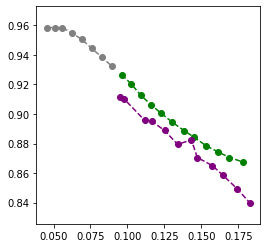

(0.015328871705703932, 0.027682840139192744)


In [ ]:
n=40
print_trayectoria(X,y,results,n)
print(average_displacement_error(results[n],y[n]))

Ejemplo de trayectoria real vrs predicción con datos denormalizados y error de la muestra:

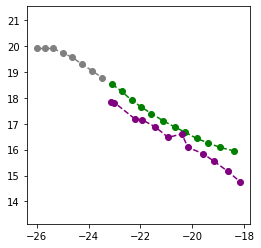

(26.026481785643124, 23.003042341270476)


In [ ]:
n=40
print_trayectoria(X_denormalized,Y_denormalized,results_denormalized,n)
print(average_displacement_error(results_denormalized[n],y[n]))

**Error ADE, FDE del training data:**

In [ ]:
#calculo de error de las trayectorias ADE, FDE con datos denormalizados
ADE_Training, FDE_Training = calculate_error_batch(results_denormalized,Y_denormalized)
print("ADE:",ADE_Training, "FDE:",FDE_Training)

ADE: 1.120096083025252 FDE: 1.7764300330741767


#####Evaluación del modelo CNN con datos de prueba

Extacción y carga de Test Data

Test Data contiene 423 trayectorias de peatones

In [ ]:
df_test = pd.read_csv('/content/drive/MyDrive/ProyectoSL2/data/standford-dataset-meters/test/bookstore_3.txt',sep=' ', header=None, names=['time','id','x','y'])

df_test.describe(include="all")

,time,id,x,y
count,8460.000000,8460.000000,8460.000000,8460.000000
mean,7846.879433,211.000000,-2.098361,-1.368573
std,4228.993127,122.116458,14.998730,12.236613
min,0.000000,0.000000,-27.486000,-20.879000
25%,3912.000000,105.000000,-19.021000,-13.469000
50%,7716.000000,211.000000,0.059000,-4.437500
75%,11640.000000,317.000000,10.752000,10.400000
max,14484.000000,422.000000,23.401000,20.664000


Normalización de datos de prueba:

In [ ]:
#Normalizar datos de test
id_column_test = df_test.id
df_test.drop(columns=['time','id'], axis=1, inplace=True) #se quita la feature time del dataset

df_test = pd.DataFrame(scaler.fit_transform(df_test), columns=df_test.columns)

df_test['id'] = id_column_test


In [ ]:
#división de features x, y para utilizarlos en el modelo de entrada multiple
X_test, y_test = sequences_to_supervised(df_test, n_steps_in, n_steps_out, n_features)

Redimension de datos de prueba para poder procesarlos con CNN

In [ ]:
y_test = y_test.reshape((y_test.shape[0], (12*2)))

#####Metricas del modelo con datos de prueba

In [ ]:
score = model.evaluate(X_test, y_test, verbose=1, batch_size=8)

print("\n")
print(model.metrics_names)
print(score)

53/53 [==============================] - 0s 1ms/step - loss: 5.0332e-04


['loss']
0.0005033228662796319


In [ ]:
#prediccion
results_test = model.predict(X_test)

In [ ]:
results_test = results_test.reshape(results_test.shape[0], 12, 2)
y_test = y_test.reshape(-1,12,2)


Denormalización de datos:

In [ ]:
#redimensionamiento para tener un array en 2D y poder denormalizar X
X_test_denormalized = np.array(X_test)
X_test_denormalized = X_test_denormalized.reshape(X_test_denormalized.shape[0]*X_test_denormalized.shape[1],X_denormalized.shape[2])
X_test_denormalized =  scaler.inverse_transform(X_test_denormalized)
X_test_denormalized = X_test_denormalized.reshape(X_test.shape[0],X_test.shape[1],X_test.shape[2])

#redimensionamiento para tener un array en 2D y poder denormalizar Y
Y_test_denormalized = np.array(y_test)
Y_test_denormalized = Y_test_denormalized.reshape(Y_test_denormalized.shape[0]*Y_test_denormalized.shape[1],Y_test_denormalized.shape[2])
Y_test_denormalized =  scaler.inverse_transform(Y_test_denormalized)
Y_test_denormalized = Y_test_denormalized.reshape(y_test.shape[0],y_test.shape[1],y_test.shape[2])

#redimensionamiento para tener un array en 2D y poder denormalizar Results
results_test_denormalized = np.array(results_test)
results_test_denormalized = results_test_denormalized.reshape(results_test_denormalized.shape[0]*results_test_denormalized.shape[1],results_test_denormalized.shape[2])
results_test_denormalized =  scaler.inverse_transform(results_test_denormalized)
results_test_denormalized = results_test_denormalized.reshape(results_test.shape[0],results_test.shape[1],results_test.shape[2])



**Error ADE, FDE del test data:**

In [ ]:
#calculo de error de las trayectorias ADE, FDE con datos denormalizados
ADE_Test, FDE_Test = calculate_error_batch(results_test_denormalized,Y_test_denormalized)
print("ADE:",ADE_Test, "FDE:",FDE_Test)

ADE: 1.0704037448249868 FDE: 1.6945706457641165


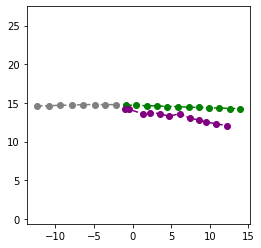

(14.540236295316499, 16.72191565024826)


In [ ]:
n=10
print_trayectoria(X_test_denormalized,Y_test_denormalized,results_test_denormalized,n)
print(average_displacement_error(results_test_denormalized[n],y[n]))